In [ ]:
import pandas as pds

from sklearn import linear_model
from sklearn import metrics
from sqlalchemy import create_engine

# Import Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData, Table

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score


# test classification dataset
from collections import Counter
from sklearn.datasets import make_classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf

import numpy as np

import random

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
# Create an engine for the chinook.sqlite database
# engine = create_engine("austincrime.cszdqowqamd3.us-east-1.rds.amazonaws.com", echo=False)
import psycopg2 as pg
import pandas.io.sql as psql
connection = pg.connect("host=austincrime.cszdqowqamd3.us-east-1.rds.amazonaws.com dbname=austincrime user=postgres password=T1m3T0Party")
# dataframe = psql.read_sql('SELECT * FROM product_product', connection)
# product_category = psql.read_sql_query('select * from product_category', connection)

In [ ]:
# create crime_df dataframe from postgres austincrimereports_filtered table

crime_df = psql.read_sql('SELECT * FROM austincrimereports_filtered', connection)
crime_df

,ID,GOHighestOffDesc,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,ReportDateTime,ReportDate,ReportTime,...,CensusTract,Clearance,ClearanceDate,UCRCategory,CategoryDescription,XCoordinate,YCoordinate,Latitude,Longitude,Location
0,20195044494,RAPE,200,N,2019-10-26 00:30:00,2019-10-26,30.0,2019-10-28 15:27:00,2019-10-28,1527,...,NaN,C,2020-07-27,11A,Rape,0.0,0.0,None,None,None
1,2019990714,BURGLARY OF RESIDENCE,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,2019-04-09 12:06:00,2019-04-09,1206,...,24.11,N,2019-06-04,220,Burglary,3111980.0,3111980.0,30.2016066,-97.75197579,"(30.2016066, -97.75197579)"
2,20192450039,THEFT,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,2019-09-02 00:48:00,2019-09-02,48,...,10.00,N,2019-09-19,23H,Theft,3121101.0,3121101.0,30.25208635,-97.72173092,"(30.25208635, -97.72173092)"
3,2019721051,BURGLARY OF RESIDENCE,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,2019-03-13 14:43:00,2019-03-13,1443,...,24.22,N,2019-06-04,220,Burglary,3100725.0,3100725.0,30.18878158,-97.78795069,"(30.18878158, -97.78795069)"
4,20198003454,THEFT OF BICYCLE,609,N,2019-09-10 00:15:00,2019-09-10,15.0,2019-09-10 14:41:00,2019-09-10,1441,...,5.00,N,2019-09-18,23H,Theft,3116746.0,3116746.0,30.30005911,-97.73423629,"(30.30005911, -97.73423629)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272896,2020461005,BURGLARY NON RESIDENCE,502,N,2020-02-14 18:00:00,2020-02-14,1800.0,2020-02-15 15:58:00,2020-02-15,1558,...,13.11,N,2020-07-16,220,Burglary,3111316.0,3111316.0,30.25891009,-97.75254744,"(30.25891009, -97.75254744)"
272897,20172100358,BURGLARY NON RESIDENCE,502,N,2017-07-29 04:21:00,2017-07-29,421.0,2017-07-29 04:21:00,2017-07-29,421,...,403.00,N,2017-08-02,220,Burglary,3129997.0,3129997.0,30.33915243,-97.69116575,"(30.33915243, -97.69116575)"
272898,20153201052,BURGLARY OF RESIDENCE,500,N,2015-11-16 15:53:00,2015-11-16,1553.0,2015-11-16 15:53:00,2015-11-16,1553,...,13.00,N,2015-11-20,220,Burglary,3104172.0,3104172.0,30.24824738,-97.77546359,"(30.24824738, -97.77546359)"
272899,20193341496,BURGLARY OF VEHICLE,601,N,2019-11-30 21:07:00,2019-11-30,2107.0,2019-11-30 21:07:00,2019-11-30,2107,...,306.00,N,2019-12-03,23F,Theft,3107108.0,3107108.0,30.34276798,-97.76364742,"(30.34276798, -97.76364742)"


In [ ]:
#checking for null data
crime_df.isnull().sum()

ID                         0
GOHighestOffDesc           0
NIBRSUCROffDesc            0
FamilyViolence             0
OccurredDateTime          67
OccurredDate               0
OccurredTime               9
ReportDateTime             0
ReportDate                 0
ReportTime                 0
LocationType             430
Address                    0
ZipCode                  906
CouncilDistrict         1781
APDSector                595
APDDistrict              635
PRA                      651
CensusTract             1549
Clearance              14767
ClearanceDate          14808
UCRCategory                0
CategoryDescription        0
XCoordinate              514
YCoordinate              514
Latitude                5660
Longitude               5660
Location                5660
dtype: int64

In [ ]:
# Generate our categorical variable list
crime_cat = crime_df.dtypes[crime_df.dtypes == "object"].index.tolist()

In [ ]:
print(crime_cat)

['ID', 'GOHighestOffDesc', 'NIBRSUCROffDesc', 'FamilyViolence', 'OccurredDate', 'ReportDate', 'LocationType', 'Address', 'ZipCode', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'Clearance', 'ClearanceDate', 'UCRCategory', 'CategoryDescription', 'Latitude', 'Longitude', 'Location']


In [ ]:
crime_df.dtypes

ID                             object
GOHighestOffDesc               object
NIBRSUCROffDesc                object
FamilyViolence                 object
OccurredDateTime       datetime64[ns]
OccurredDate                   object
OccurredTime                  float64
ReportDateTime         datetime64[ns]
ReportDate                     object
ReportTime                      int64
LocationType                   object
Address                        object
ZipCode                        object
CouncilDistrict                object
APDSector                      object
APDDistrict                    object
PRA                            object
CensusTract                   float64
Clearance                      object
ClearanceDate                  object
UCRCategory                    object
CategoryDescription            object
XCoordinate                   float64
YCoordinate                   float64
Latitude                       object
Longitude                      object
Location    

In [ ]:
# Changing Longitude and Latitude to float

crime_df["Longitude"] = crime_df.Longitude.astype(float)
crime_df["Latitude"] = crime_df.Latitude.astype(float)

In [ ]:
# Dropping columns
cleaned_crime_df = crime_df.drop(['ID','GOHighestOffDesc','Location', 'ClearanceDate', 'Clearance','XCoordinate','YCoordinate','Location','Address','ReportDateTime','ReportDate','ReportTime'],axis = 1)
print(cleaned_crime_df.count())

NIBRSUCROffDesc        272901
FamilyViolence         272901
OccurredDateTime       272834
OccurredDate           272901
OccurredTime           272892
LocationType           272471
ZipCode                271995
CouncilDistrict        271120
APDSector              272306
APDDistrict            272266
PRA                    272250
CensusTract            271352
UCRCategory            272901
CategoryDescription    272901
Latitude               267241
Longitude              267241
dtype: int64


In [ ]:
# Check for null values
cleaned_crime_df.isnull().sum()

NIBRSUCROffDesc           0
FamilyViolence            0
OccurredDateTime         67
OccurredDate              0
OccurredTime              9
LocationType            430
ZipCode                 906
CouncilDistrict        1781
APDSector               595
APDDistrict             635
PRA                     651
CensusTract            1549
UCRCategory               0
CategoryDescription       0
Latitude               5660
Longitude              5660
dtype: int64

In [ ]:
# Drop the null rows
cleaned_crime_df = cleaned_crime_df.dropna()
print(cleaned_crime_df.count())

NIBRSUCROffDesc        265102
FamilyViolence         265102
OccurredDateTime       265102
OccurredDate           265102
OccurredTime           265102
LocationType           265102
ZipCode                265102
CouncilDistrict        265102
APDSector              265102
APDDistrict            265102
PRA                    265102
CensusTract            265102
UCRCategory            265102
CategoryDescription    265102
Latitude               265102
Longitude              265102
dtype: int64


In [ ]:
cleaned_crime_df.describe()

,OccurredTime,CensusTract,Latitude,Longitude
count,265102.000000,265102.000000,265102.000000,265102.000000
mean,1322.291974,196.663368,30.298767,-97.737164
std,688.784188,678.339344,0.079130,0.047594
min,0.000000,1.000000,30.100612,-97.929669
25%,845.000000,15.000000,30.235325,-97.764662
50%,1430.000000,24.000000,30.288806,-97.734539
75%,1900.000000,341.000000,30.360760,-97.704491
max,2359.000000,9800.000000,30.513667,-97.578053


In [ ]:
# putting Latitudes and Longitudes in Bins
lat_labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
cleaned_crime_df['Latitude_bin'] = pds.qcut(cleaned_crime_df['Latitude'],
                                                    q=20,labels  = lat_labels, precision = 4)
long_labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
cleaned_crime_df['Longitude_bin'] = pds.qcut(cleaned_crime_df['Longitude'],
                                                    q=20,labels  = lat_labels, precision = 4)



cleaned_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,3,7
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,7,13
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,2,3
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,11,11
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,10,8


In [ ]:
# making ZipCode an integer datatype

# cleaned_crime_df['ZipCode'] = cleaned_crime_df['ZipCode'].astype(str).astype(int)
# cleaned_crime_df.head(100)

In [ ]:
# checking number of unique values per column
cleaned_crime_df.nunique()

NIBRSUCROffDesc            44
FamilyViolence              2
OccurredDateTime       193615
OccurredDate             2628
OccurredTime             1440
LocationType               45
ZipCode                    50
CouncilDistrict            10
APDSector                  12
APDDistrict                15
PRA                       509
CensusTract               251
UCRCategory                13
CategoryDescription         6
Latitude                64293
Longitude               64235
Latitude_bin               20
Longitude_bin              20
dtype: int64

In [ ]:
# separating out month and day 
cleaned_crime_df['OccurredDate_Month'] = pds.DatetimeIndex(cleaned_crime_df['OccurredDate']).month
cleaned_crime_df['OccurredDate_Day'] = pds.DatetimeIndex(cleaned_crime_df['OccurredDate']).day
cleaned_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,3,7,4,9
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,7,13,9,1
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,2,3,3,13
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,11,11,9,10
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,10,8,9,9


In [ ]:
# Adding day of the week column

cleaned_crime_df['OccurredDate'] = pds.to_datetime(cleaned_crime_df['OccurredDate'])
cleaned_crime_df['OccurredDate_DayOfWeek'] = cleaned_crime_df['OccurredDate'].dt.dayofweek
cleaned_crime_df.head()


,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,...,24.11,220,Burglary,30.201607,-97.751976,3,7,4,9,1
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,...,10.00,23H,Theft,30.252086,-97.721731,7,13,9,1,6
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,...,24.22,220,Burglary,30.188782,-97.787951,2,3,3,13,2
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,...,5.00,23H,Theft,30.300059,-97.734236,11,11,9,10,1
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,...,7.00,23H,Theft,30.282249,-97.746682,10,8,9,9,0


In [ ]:
# making OccurredTime an integer datatype for example 10:45 pm would be 2245

cleaned_crime_df['OccurredTime'] = cleaned_crime_df['OccurredTime'].astype(int)
cleaned_crime_df.head(100)

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
1,500,N,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,24.11,220,Burglary,30.201607,-97.751976,3,7,4,9,1
2,600,N,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,10.00,23H,Theft,30.252086,-97.721731,7,13,9,1,6
3,500,N,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,24.22,220,Burglary,30.188782,-97.787951,2,3,3,13,2
4,609,N,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,5.00,23H,Theft,30.300059,-97.734236,11,11,9,10,1
6,600,N,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,7.00,23H,Theft,30.282249,-97.746682,10,8,9,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,8503,N,2021-09-13 14:20:00,2021-09-13,1420,RESIDENCE / HOME,78750,6,AD,6,...,204.00,23H,Theft,30.443136,-97.787508,20,4,9,13,0
147,600,N,2019-09-30 19:10:00,2019-09-30,1910,RESTAURANTS,78754,1,ID,2,...,18.11,23H,Theft,30.330775,-97.682517,14,18,9,30,0
148,410,Y,2019-09-24 03:00:00,2019-09-24,300,RESIDENCE / HOME,78753,4,ED,3,...,18.13,13A,Aggravated Assault,30.352738,-97.691219,15,17,9,24,1
149,402,Y,2021-11-04 21:15:00,2021-11-04,2115,RESIDENCE / HOME,78758,4,ED,4,...,419.00,13A,Aggravated Assault,30.383586,-97.696014,17,17,11,4,3


In [ ]:
# creating OccurredHour to help group crimes by the hour
cleaned_crime_df['OccurredHour'] = (cleaned_crime_df['OccurredTime'] / 100).apply(np.floor).astype(int) *100
cleaned_crime_df.head()


,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
1,500,N,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,220,Burglary,30.201607,-97.751976,3,7,4,9,1,1200
2,600,N,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,23H,Theft,30.252086,-97.721731,7,13,9,1,6,2100
3,500,N,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,220,Burglary,30.188782,-97.787951,2,3,3,13,2,1400
4,609,N,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,23H,Theft,30.300059,-97.734236,11,11,9,10,1,0
6,600,N,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,23H,Theft,30.282249,-97.746682,10,8,9,9,0,1300


In [ ]:
# Generate our categorical variable list
crime_cat = cleaned_crime_df.dtypes[cleaned_crime_df.dtypes == "object"].index.tolist()
print(crime_cat)

['NIBRSUCROffDesc', 'FamilyViolence', 'LocationType', 'ZipCode', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'UCRCategory', 'CategoryDescription']


In [ ]:
crime_type_counts = cleaned_crime_df.CategoryDescription.value_counts()
crime_type_counts

Theft                 188733
Burglary               32649
Auto Theft             20441
Aggravated Assault     16024
Robbery                 6978
Murder                   277
Name: CategoryDescription, dtype: int64

In [ ]:
# 'LocationType', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'UCRCategory', 'CategoryDescription']
#  "FamilyViolence","OccurredTime","LocationType","ZipCode","CouncilDistrict","APDSector","Latitude_bin","Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"

LocationType_counts = cleaned_crime_df.LocationType.value_counts()
LocationType_counts

# Determine which values to replace if counts are less than ...?
replace_locationType = list(LocationType_counts[LocationType_counts < 150].index)

# Replace in dataframe
for location in replace_locationType:
    cleaned_crime_df.LocationType = cleaned_crime_df.LocationType.replace(location,"Other")
    
# Check to make sure binning was successful
cleaned_crime_df.LocationType.value_counts()



RESIDENCE / HOME                                  91837
PARKING LOTS / GARAGE                             49659
STREETS / HWY / ROAD / ALLEY                      22522
OTHER / UNKNOWN                                   22086
DEPARTMENT / DISCOUNT STORE                       13088
COMMERCIAL / OFFICE BUILDING                      11059
GROCERY / SUPERMARKET                              9151
RESTAURANTS                                        5855
HOTEL / MOTEL / ETC.                               5614
CONVENIENCE STORE                                  5136
BAR / NIGHT CLUB                                   3715
SPECIALTY  STORE (TV  FUR ETC.)                    3443
GAS / SERVICE STATIONS                             3390
PARK / PLAYGROUND                                  2611
CONSTRUCTION SITE                                  2332
RENTAL STORAGE FACILITY                            1941
DRUG STORE / DR. OFFICE / HOSPITAL                 1802
LIQUOR STORE                                    

In [ ]:
#changing FamilyViolence to 0s and 1s instead of y and n

cleaned_crime_df.FamilyViolence.replace(('Y', 'N'), (1, 0), inplace=True)
cleaned_crime_df['FamilyViolence'] = cleaned_crime_df['FamilyViolence'].astype(bool)

# changing CouncilDistrict to integer
cleaned_crime_df['CouncilDistrict'] = cleaned_crime_df['CouncilDistrict'].astype(int)


# changing PRA to integer
cleaned_crime_df['PRA'] = cleaned_crime_df['PRA'].astype(int)
cleaned_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,220,Burglary,30.201607,-97.751976,3,7,4,9,1,1200
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,23H,Theft,30.252086,-97.721731,7,13,9,1,6,2100
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,220,Burglary,30.188782,-97.787951,2,3,3,13,2,1400
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,23H,Theft,30.300059,-97.734236,11,11,9,10,1,0
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,23H,Theft,30.282249,-97.746682,10,8,9,9,0,1300


In [ ]:
# Generate our categorical variable list
crime_cat = cleaned_crime_df.dtypes[cleaned_crime_df.dtypes == "object"].index.tolist()
print(crime_cat)


['NIBRSUCROffDesc', 'LocationType', 'ZipCode', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [ ]:
location_freq = cleaned_crime_df['LocationType'].value_counts()
# print(location_freq)
num_locations = len(location_freq)
locations = location_freq.keys()
location_dist = {}
for loc in range(num_locations):
    location_key = locations[loc]
    location_dist[location_key] = round(location_freq.values[loc] / cleaned_crime_df.shape[0], 5)
    
location_dist

{'ABANDONED/CONDEMNED STRUCTURE': 0.00152,
 'AUTO DEALERSHIP NEW / USED': 0.00394,
 'BANKS / SAVINGS & LOAN': 0.00202,
 'BAR / NIGHT CLUB': 0.01401,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 0.00231,
 'COMMERCIAL / OFFICE BUILDING': 0.04172,
 'COMMUNITY CENTER': 0.00098,
 'CONSTRUCTION SITE': 0.0088,
 'CONVENIENCE STORE': 0.01937,
 'DEPARTMENT / DISCOUNT STORE': 0.04937,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 0.0068,
 'FIELD / WOODS': 0.00193,
 'GAS / SERVICE STATIONS': 0.01279,
 'GOVERNMENT / PUBLIC BUILDING': 0.00442,
 'GROCERY / SUPERMARKET': 0.03452,
 'HOTEL / MOTEL / ETC.': 0.02118,
 'LAKE / WATERWAY': 0.00065,
 'LIQUOR STORE': 0.0055,
 'OTHER / UNKNOWN': 0.08331,
 'Other': 0.00255,
 'PARK / PLAYGROUND': 0.00985,
 'PARKING LOTS / GARAGE': 0.18732,
 'RENTAL STORAGE FACILITY': 0.00732,
 'RESIDENCE / HOME': 0.34642,
 'RESTAURANTS': 0.02209,
 'SCHOOL - COLLEGE / UNIVERSITY': 0.00071,
 'SCHOOL - ELEMENTARY / SECONDARY': 0.00075,
 'SCHOOLS / COLLEGES': 0.0009,
 'SHELTER-MISSION / HOMELES

In [ ]:
ranking_dict = {}

for i in range(33):
    location_key = locations[i]
    
    ranking_dict[location_key] = i + 1
    
ranking_dict

{'ABANDONED/CONDEMNED STRUCTURE': 27,
 'AUTO DEALERSHIP NEW / USED': 22,
 'BANKS / SAVINGS & LOAN': 25,
 'BAR / NIGHT CLUB': 11,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 24,
 'COMMERCIAL / OFFICE BUILDING': 6,
 'COMMUNITY CENTER': 28,
 'CONSTRUCTION SITE': 15,
 'CONVENIENCE STORE': 10,
 'DEPARTMENT / DISCOUNT STORE': 5,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 17,
 'FIELD / WOODS': 26,
 'GAS / SERVICE STATIONS': 13,
 'GOVERNMENT / PUBLIC BUILDING': 19,
 'GROCERY / SUPERMARKET': 7,
 'HOTEL / MOTEL / ETC.': 9,
 'LAKE / WATERWAY': 33,
 'LIQUOR STORE': 18,
 'OTHER / UNKNOWN': 4,
 'Other': 23,
 'PARK / PLAYGROUND': 14,
 'PARKING LOTS / GARAGE': 2,
 'RENTAL STORAGE FACILITY': 16,
 'RESIDENCE / HOME': 1,
 'RESTAURANTS': 8,
 'SCHOOL - COLLEGE / UNIVERSITY': 31,
 'SCHOOL - ELEMENTARY / SECONDARY': 30,
 'SCHOOLS / COLLEGES': 29,
 'SHELTER-MISSION / HOMELESS': 32,
 'SHOPPING MALL': 20,
 'SPECIALTY  STORE (TV  FUR ETC.)': 12,
 'STREETS / HWY / ROAD / ALLEY': 3,
 'TRANSPORTATION (AIR / BUS / TRAIN - 

In [ ]:
crime_cat = ['LocationType']

In [ ]:
parent = cleaned_crime_df.copy()[crime_cat]
pen= cleaned_crime_df.copy()[crime_cat]
apple = cleaned_crime_df.copy()[crime_cat]
parent['ranking']=pen.replace(ranking_dict)
parent['location_dist'] = pen.replace(location_dist)

cleaned_crime_df["location_ranking"] = parent["ranking"]
cleaned_crime_df["location_dist"] = parent["location_dist"]
cleaned_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,30.201607,-97.751976,3,7,4,9,1,1200,1,0.34642
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,30.252086,-97.721731,7,13,9,1,6,2100,1,0.34642
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,30.188782,-97.787951,2,3,3,13,2,1400,1,0.34642
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,30.300059,-97.734236,11,11,9,10,1,0,1,0.34642
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,30.282249,-97.746682,10,8,9,9,0,1300,1,0.34642


In [ ]:
# Create a OneHotEncoder instance
# enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
# encode_df = pds.DataFrame(enc.fit_transform(cleaned_crime_df[crime_cat]))
# Add the encoded variable names to the DataFrame
# encode_df.columns = enc.get_feature_names(crime_cat)
# encode_df.head()

In [ ]:
# Merge one-hot encoded features and drop the originals
# ml_cleaned_crime_df = cleaned_crime_df.merge(encode_df,left_index=True,right_index=True)
# ml_cleaned_crime_df = cleaned_crime_df.drop(columns=crime_cat, axis=1)
# ml_cleaned_crime_df.head()

In [ ]:
# Remove CategoryDescription target from features data
y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin",
# "OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = cleaned_crime_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","APDSector","APDDistrict",
                              "UCRCategory","CategoryDescription","Latitude","Longitude","OccurredDate_Day"],axis = 1).values
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")


 Random forest predictive accuracy: 0.732


In [ ]:
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Aggravated Assault       0.80      0.51      0.63      4006
        Auto Theft       0.25      0.07      0.11      5110
          Burglary       0.48      0.23      0.31      8162
            Murder       0.11      0.01      0.03        69
           Robbery       0.22      0.04      0.07      1745
             Theft       0.76      0.94      0.84     47184

          accuracy                           0.73     66276
         macro avg       0.44      0.30      0.33     66276
      weighted avg       0.67      0.73      0.68     66276



In [ ]:
precision, r, f,s = precision_recall_fscore_support(y_test,y_pred)

In [ ]:
precision

array([0.79798762, 0.25016949, 0.4803516 , 0.11111111, 0.21910112,
       0.76143419])

In [ ]:
y.value_counts()

#random forest, logistics regression, or gradient boosted trres {sklearn and xgboost}

# sampling
    # over sampling
    # under sampling
    # data augmentation
    # from imbalanced-learn package

Theft                 188733
Burglary               32649
Auto Theft             20441
Aggravated Assault     16024
Robbery                 6978
Murder                   277
Name: CategoryDescription, dtype: int64

In [ ]:
# Multinomial Logistic Regression, CensusTract
# y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df.CensusTract
# X = cleaned_crime_df.CensusTract.values.reshape(-1, 1)

y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = cleaned_crime_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","APDSector","APDDistrict","UCRCategory","CategoryDescription","Latitude","Longitude","OccurredDate_Day"],axis = 1).values
# Split training/test datasets
X

array([[False, 1206, '78744', ..., 1200, 1, 0.34642],
       [False, 2145, '78702', ..., 2100, 1, 0.34642],
       [False, 1443, '78745', ..., 1400, 1, 0.34642],
       ...,
       [False, 1553, '78704', ..., 1500, 1, 0.34642],
       [False, 2107, '78731', ..., 2100, 3, 0.08496],
       [False, 600, '78704', ..., 600, 3, 0.08496]], dtype=object)

In [ ]:
# Multinomial Logistic Regression, CensusTract
# y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df.CensusTract
# X = cleaned_crime_df.CensusTract.values.reshape(-1, 1)

y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = cleaned_crime_df.drop(["NIBRSUCROffDesc","OccurredDateTime","OccurredDate",
                              "APDSector","APDDistrict","UCRCategory","CategoryDescription",
                              "Latitude","Longitude","OccurredDate_Day"],axis = 1).values
# Split training/test datasets

X



array([[False, 1206, 'RESIDENCE / HOME', ..., 1200, 1, 0.34642],
       [False, 2145, 'RESIDENCE / HOME', ..., 2100, 1, 0.34642],
       [False, 1443, 'RESIDENCE / HOME', ..., 1400, 1, 0.34642],
       ...,
       [False, 1553, 'RESIDENCE / HOME', ..., 1500, 1, 0.34642],
       [False, 2107, 'STREETS / HWY / ROAD / ALLEY', ..., 2100, 3,
        0.08496],
       [False, 600, 'STREETS / HWY / ROAD / ALLEY', ..., 600, 3, 0.08496]],
      dtype=object)

In [ ]:
X.reshape(1, -1)

array([[False, 1206, 'RESIDENCE / HOME', ..., 600, 3, 0.08496]],
      dtype=object)

In [ ]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',)
# fit the model on the whole dataset
model.fit(X_train_scaled, y_train)

# define a single row of input data
census_tract_list= cleaned_crime_df.CensusTract.unique().tolist()
random_census_tract= random.choice(census_tract_list)
census_tract= [random_census_tract]


For each iteration, reshape the array to (1,-1) 
then pass the reshaped array into the model

In [ ]:
# predict the class label
yhat = model.predict(X_test_scaled)
yhat
# summarize the predicted class
# print('Census Tract: %s, Predicted Crime Type: %s' % (census_tract, yhat[0]))

array(['Theft', 'Theft', 'Theft', ..., 'Theft', 'Theft', 'Theft'],
      dtype=object)

In [ ]:
print(classification_report(y_test, yhat))

                    precision    recall  f1-score   support

Aggravated Assault       0.92      0.48      0.63      4006
        Auto Theft       0.00      0.00      0.00      5110
          Burglary       0.16      0.00      0.00      8162
            Murder       0.00      0.00      0.00        69
           Robbery       0.00      0.00      0.00      1745
             Theft       0.73      1.00      0.85     47184

          accuracy                           0.74     66276
         macro avg       0.30      0.25      0.25     66276
      weighted avg       0.60      0.74      0.64     66276



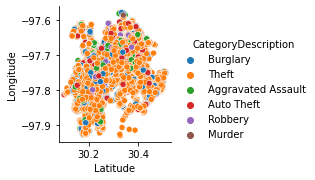

In [ ]:
sns.pairplot(cleaned_crime_df,x_vars=['Latitude',],y_vars=['Longitude'],hue='CategoryDescription')

In [ ]:
cenustracts = cleaned_crime_df.CensusTract.value_counts()
cenustracts

11.00     12955
21.00     10297
3.00       8473
15.00      7213
9.00       6315
          ...  
24.35         1
23.07         1
18.49         1
18.56         1
349.00        1
Name: CensusTract, Length: 251, dtype: int64

In [ ]:
# create crime_census_df dataframe from postgres austincrimereport_with_censustract table
crime_census_df = psql.read_sql('SELECT * FROM austincrimereport_with_censustract', connection)

In [ ]:
# Generate our categorical variable list
crime_cat = crime_census_df.dtypes[crime_census_df.dtypes == "object"].index.tolist()

In [ ]:
print(crime_cat)

['ID', 'GOHighestOffDesc', 'NIBRSUCROffDesc', 'FamilyViolence', 'OccurredDate', 'ReportDate', 'LocationType', 'Address', 'ZipCode', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'Clearance', 'ClearanceDate', 'UCRCategory', 'CategoryDescription', 'Latitude', 'Longitude', 'Location', 'the_geom', 'County', 'Loc']


In [ ]:
# Changing Longitude and Latitude to float

crime_census_df["Longitude"] = crime_census_df.Longitude.astype(float)
crime_census_df["Latitude"] = crime_census_df.Latitude.astype(float)

In [ ]:
# Dropping columns
cleaned_crime_census_df = crime_census_df.drop(['ID','GOHighestOffDesc','Location', 'ClearanceDate', 'Clearance','XCoordinate','YCoordinate','Location','Address','ReportDateTime','ReportDate','ReportTime', 'the_geom', 'County', 'Loc'],axis = 1)
print(cleaned_crime_census_df.count())

NIBRSUCROffDesc                                      74128
FamilyViolence                                       74128
OccurredDateTime                                     74109
OccurredDate                                         74128
OccurredTime                                         74125
LocationType                                         74025
ZipCode                                              74128
CouncilDistrict                                      73893
APDSector                                            74128
APDDistrict                                          74128
PRA                                                  74128
CensusTract                                          74128
UCRCategory                                          74128
CategoryDescription                                  74128
Latitude                                             72713
Longitude                                            72713
Census_Tract                                         741

In [ ]:
# Drop the null rows
cleaned_crime_census_df = cleaned_crime_census_df.dropna()
print(cleaned_crime_census_df.count())

NIBRSUCROffDesc                                      72366
FamilyViolence                                       72366
OccurredDateTime                                     72366
OccurredDate                                         72366
OccurredTime                                         72366
LocationType                                         72366
ZipCode                                              72366
CouncilDistrict                                      72366
APDSector                                            72366
APDDistrict                                          72366
PRA                                                  72366
CensusTract                                          72366
UCRCategory                                          72366
CategoryDescription                                  72366
Latitude                                             72366
Longitude                                            72366
Census_Tract                                         723

In [ ]:
cleaned_crime_census_df.describe()

,OccurredTime,CensusTract,Latitude,Longitude,Census_Tract,AREA_SQMI,EstimatedTotalPopulation,EstimatedPersonsBelowPoverty,EstimatedPctPersonsBelowPoverty,EstimatedUnemployed,UnemploymentRateEstimate,PctPersonsNoHighSchoolDiploma,PerCapitaIncomeEstimate,SumOfFlagsForSocioeconomicStatus
count,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000,72366.000000
mean,1300.744991,186.180960,30.272207,-97.741163,186.180960,38.297686,4496.894674,731.641406,0.158451,122.583644,4.497358,14.949467,49554.208855,0.130835
std,705.369384,1263.063699,0.058054,0.036604,1263.063699,74.403796,1420.490250,562.626587,0.104633,92.764108,3.432012,12.796405,41510.688368,0.415037
min,0.000000,1.000000,30.107568,-97.914194,1.000000,0.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,800.000000,7.000000,30.234429,-97.757962,7.000000,0.940000,3151.000000,340.000000,0.089000,53.000000,1.800000,4.100000,20094.000000,0.000000
50%,1412.000000,19.100000,30.267764,-97.739178,19.100000,1.260000,4927.000000,542.000000,0.119000,82.000000,3.700000,15.700000,28954.000000,0.000000
75%,1900.000000,23.150000,30.300464,-97.722889,23.150000,6.750000,5719.000000,1161.000000,0.244000,159.000000,6.400000,22.200000,63803.000000,0.000000
max,2359.000000,9800.000000,30.503306,-97.611494,9800.000000,236.260000,17139.000000,3380.000000,0.867000,494.000000,29.400000,44.900000,130580.000000,3.000000


In [ ]:
# putting Latitudes and Longitudes in Bins
lat_labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
cleaned_crime_census_df['Latitude_bin'] = pds.qcut(cleaned_crime_census_df['Latitude'],
                                                    q=20,labels  = lat_labels, precision = 4)
long_labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
cleaned_crime_census_df['Longitude_bin'] = pds.qcut(cleaned_crime_census_df['Longitude'],
                                                    q=20,labels  = lat_labels, precision = 4)

cleaned_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,EstimatedUnemployed,UnemploymentRateEstimate,FlagPctCivilianUnemployedIn90thPercentile,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,Latitude_bin,Longitude_bin
0,700,N,2019-09-20 17:00:00,2019-09-20,1700.0,STREETS / HWY / ROAD / ALLEY,78701,9,BA,1,...,49,6.4,False,1.0,False,60116,False,0,13,9
1,604,N,2019-04-05 13:00:00,2019-04-05,1300.0,RESIDENCE / HOME,78759,10,AD,7,...,243,6.7,False,1.4,False,45976,False,0,20,7
2,601,N,2019-10-01 15:30:00,2019-10-01,1530.0,OTHER / UNKNOWN,78745,2,FR,3,...,255,6.9,False,14.4,False,25694,False,0,1,3
3,601,N,2019-09-27 02:00:00,2019-09-27,200.0,PARKING LOTS / GARAGE,78717,6,AD,5,...,49,1.7,False,1.1,False,42253,False,0,20,3
4,617,N,2019-09-30 18:15:00,2019-09-30,1815.0,HOTEL / MOTEL / ETC.,78701,9,GE,3,...,78,1.8,False,4.1,False,130580,False,0,8,8


In [ ]:
# checking number of unique values per column
cleaned_crime_census_df.nunique()

NIBRSUCROffDesc                                         38
FamilyViolence                                           2
OccurredDateTime                                     63530
OccurredDate                                          2628
OccurredTime                                          1440
LocationType                                            43
ZipCode                                                 38
CouncilDistrict                                         10
APDSector                                               12
APDDistrict                                             15
PRA                                                    241
CensusTract                                             90
UCRCategory                                             13
CategoryDescription                                      6
Latitude                                             16496
Longitude                                            16496
Census_Tract                                            

In [ ]:
zipcode_counts = cleaned_crime_census_df.ZipCode.value_counts()
zipcode_counts

78701    14434
78741     7257
78723     5854
78744     5819
78746     5660
78751     4984
78745     3405
78705     2982
78756     2518
78721     2427
78703     2379
78722     2007
78731     1704
78759     1623
78717     1600
78702     1583
78735     1342
78748     1145
78719     1105
78617      758
78729      600
78724      285
78742      281
78704      165
78730      144
78725      103
78727       81
78753       36
78754       27
78712       25
78739       11
78758        8
78752        5
78757        4
78610        2
78750        1
78726        1
78733        1
Name: ZipCode, dtype: int64

In [ ]:
# separating out month and day 
cleaned_crime_census_df['OccurredDate_Month'] = pds.DatetimeIndex(cleaned_crime_census_df['OccurredDate']).month
cleaned_crime_census_df['OccurredDate_Day'] = pds.DatetimeIndex(cleaned_crime_census_df['OccurredDate']).day
cleaned_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,FlagPctCivilianUnemployedIn90thPercentile,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day
0,700,N,2019-09-20 17:00:00,2019-09-20,1700.0,STREETS / HWY / ROAD / ALLEY,78701,9,BA,1,...,False,1.0,False,60116,False,0,13,9,9,20
1,604,N,2019-04-05 13:00:00,2019-04-05,1300.0,RESIDENCE / HOME,78759,10,AD,7,...,False,1.4,False,45976,False,0,20,7,4,5
2,601,N,2019-10-01 15:30:00,2019-10-01,1530.0,OTHER / UNKNOWN,78745,2,FR,3,...,False,14.4,False,25694,False,0,1,3,10,1
3,601,N,2019-09-27 02:00:00,2019-09-27,200.0,PARKING LOTS / GARAGE,78717,6,AD,5,...,False,1.1,False,42253,False,0,20,3,9,27
4,617,N,2019-09-30 18:15:00,2019-09-30,1815.0,HOTEL / MOTEL / ETC.,78701,9,GE,3,...,False,4.1,False,130580,False,0,8,8,9,30


In [ ]:
# Adding day of the week column

cleaned_crime_census_df['OccurredDate'] = pds.to_datetime(cleaned_crime_census_df['OccurredDate'])
cleaned_crime_census_df['OccurredDate_DayOfWeek'] = cleaned_crime_census_df['OccurredDate'].dt.dayofweek
cleaned_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
0,700,N,2019-09-20 17:00:00,2019-09-20,1700.0,STREETS / HWY / ROAD / ALLEY,78701,9,BA,1,...,1.0,False,60116,False,0,13,9,9,20,4
1,604,N,2019-04-05 13:00:00,2019-04-05,1300.0,RESIDENCE / HOME,78759,10,AD,7,...,1.4,False,45976,False,0,20,7,4,5,4
2,601,N,2019-10-01 15:30:00,2019-10-01,1530.0,OTHER / UNKNOWN,78745,2,FR,3,...,14.4,False,25694,False,0,1,3,10,1,1
3,601,N,2019-09-27 02:00:00,2019-09-27,200.0,PARKING LOTS / GARAGE,78717,6,AD,5,...,1.1,False,42253,False,0,20,3,9,27,4
4,617,N,2019-09-30 18:15:00,2019-09-30,1815.0,HOTEL / MOTEL / ETC.,78701,9,GE,3,...,4.1,False,130580,False,0,8,8,9,30,0


In [ ]:
# making OccurredTime an integer datatype

cleaned_crime_census_df['OccurredTime'] = cleaned_crime_census_df['OccurredTime'].astype(int)
cleaned_crime_census_df.head(100)

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
0,700,N,2019-09-20 17:00:00,2019-09-20,1700,STREETS / HWY / ROAD / ALLEY,78701,9,BA,1,...,1.0,False,60116,False,0,13,9,9,20,4
1,604,N,2019-04-05 13:00:00,2019-04-05,1300,RESIDENCE / HOME,78759,10,AD,7,...,1.4,False,45976,False,0,20,7,4,5,4
2,601,N,2019-10-01 15:30:00,2019-10-01,1530,OTHER / UNKNOWN,78745,2,FR,3,...,14.4,False,25694,False,0,1,3,10,1,1
3,601,N,2019-09-27 02:00:00,2019-09-27,200,PARKING LOTS / GARAGE,78717,6,AD,5,...,1.1,False,42253,False,0,20,3,9,27,4
4,617,N,2019-09-30 18:15:00,2019-09-30,1815,HOTEL / MOTEL / ETC.,78701,9,GE,3,...,4.1,False,130580,False,0,8,8,9,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,600,N,2020-05-27 22:00:00,2020-05-27,2200,RESIDENCE / HOME,78723,9,BA,4,...,19.5,False,27412,False,0,15,18,5,27,2
105,601,N,2017-02-13 21:30:00,2017-02-13,2130,RESIDENCE / HOME,78748,5,FR,3,...,7.1,False,33061,False,0,1,1,2,13,0
106,609,N,2020-05-29 20:00:00,2020-05-29,2000,RESIDENCE / HOME,78729,6,AD,4,...,8.0,False,36109,False,0,20,4,5,29,4
107,600,N,2015-03-14 10:00:00,2015-03-14,1000,RESIDENCE / HOME,78744,2,FR,8,...,15.7,False,18469,False,0,2,5,3,14,5


In [ ]:
# creating OccurredHour to help group crimes by the hour
cleaned_crime_census_df['OccurredHour'] = (cleaned_crime_census_df['OccurredTime'] / 100).apply(np.floor).astype(int) *100
cleaned_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
0,700,N,2019-09-20 17:00:00,2019-09-20,1700,STREETS / HWY / ROAD / ALLEY,78701,9,BA,1,...,False,60116,False,0,13,9,9,20,4,1700
1,604,N,2019-04-05 13:00:00,2019-04-05,1300,RESIDENCE / HOME,78759,10,AD,7,...,False,45976,False,0,20,7,4,5,4,1300
2,601,N,2019-10-01 15:30:00,2019-10-01,1530,OTHER / UNKNOWN,78745,2,FR,3,...,False,25694,False,0,1,3,10,1,1,1500
3,601,N,2019-09-27 02:00:00,2019-09-27,200,PARKING LOTS / GARAGE,78717,6,AD,5,...,False,42253,False,0,20,3,9,27,4,200
4,617,N,2019-09-30 18:15:00,2019-09-30,1815,HOTEL / MOTEL / ETC.,78701,9,GE,3,...,False,130580,False,0,8,8,9,30,0,1800


In [ ]:
# Generate our categorical variable list
crime_cat = cleaned_crime_census_df.dtypes[cleaned_crime_census_df.dtypes == "object"].index.tolist()
print(crime_cat)

['NIBRSUCROffDesc', 'FamilyViolence', 'LocationType', 'ZipCode', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'UCRCategory', 'CategoryDescription']


In [ ]:
#changing FamilyViolence to 0s and 1s instead of y and n

cleaned_crime_census_df.FamilyViolence.replace(('Y', 'N'), (1, 0), inplace=True)
cleaned_crime_census_df['FamilyViolence'] = cleaned_crime_census_df['FamilyViolence'].astype(bool)

# changing CouncilDistrict to integer
cleaned_crime_census_df['CouncilDistrict'] = cleaned_crime_census_df['CouncilDistrict'].astype(int)


# changing PRA to integer
cleaned_crime_census_df['PRA'] = cleaned_crime_census_df['PRA'].astype(int)
cleaned_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
0,700,False,2019-09-20 17:00:00,2019-09-20,1700,STREETS / HWY / ROAD / ALLEY,78701,9,BA,1,...,False,60116,False,0,13,9,9,20,4,1700
1,604,False,2019-04-05 13:00:00,2019-04-05,1300,RESIDENCE / HOME,78759,10,AD,7,...,False,45976,False,0,20,7,4,5,4,1300
2,601,False,2019-10-01 15:30:00,2019-10-01,1530,OTHER / UNKNOWN,78745,2,FR,3,...,False,25694,False,0,1,3,10,1,1,1500
3,601,False,2019-09-27 02:00:00,2019-09-27,200,PARKING LOTS / GARAGE,78717,6,AD,5,...,False,42253,False,0,20,3,9,27,4,200
4,617,False,2019-09-30 18:15:00,2019-09-30,1815,HOTEL / MOTEL / ETC.,78701,9,GE,3,...,False,130580,False,0,8,8,9,30,0,1800


In [ ]:
# Generate our categorical variable list
crime_cat = cleaned_crime_census_df.dtypes[cleaned_crime_census_df.dtypes == "object"].index.tolist()
print(crime_cat)

['NIBRSUCROffDesc', 'LocationType', 'ZipCode', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [ ]:
# Find frequency pct of each LocationType

location_freq = cleaned_crime_census_df['LocationType'].value_counts()
num_locations = len(location_freq)
locations = location_freq.keys()
location_dist = {}
for loc in range(num_locations):
    location_key = locations[loc]
    location_dist[location_key] = round(location_freq.values[loc] / cleaned_crime_census_df.shape[0], 5)
    
location_dist

{'ABANDONED/CONDEMNED STRUCTURE': 0.00155,
 'AMUSEMENT PARK': 0.00011,
 'ARENA / STADIUM / FAIRGROUNDS / COLISEUM': 0.00039,
 'ATM SEPARATE FROM BANK': 0.00021,
 'AUTO DEALERSHIP NEW / USED': 0.00286,
 'BANKS / SAVINGS & LOAN': 0.00192,
 'BAR / NIGHT CLUB': 0.03756,
 'CAMP / CAMPGROUND': 0.00035,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 0.00202,
 'COMMERCIAL / OFFICE BUILDING': 0.03869,
 'COMMUNITY CENTER': 0.00135,
 'CONSTRUCTION SITE': 0.00938,
 'CONVENIENCE STORE': 0.01817,
 'DAYCARE FACILITY': 0.00036,
 'DEPARTMENT / DISCOUNT STORE': 0.02872,
 'DOCK / WHARF / FREIGHT / MODAL TERMINAL': 0.00019,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 0.00894,
 'FIELD / WOODS': 0.00362,
 'GAMBLING FACILITY / CASINO / RACE TRACK': 0.00032,
 'GAS / SERVICE STATIONS': 0.0105,
 'GOVERNMENT / PUBLIC BUILDING': 0.01059,
 'GROCERY / SUPERMARKET': 0.0271,
 'HOTEL / MOTEL / ETC.': 0.02136,
 'INDUSTRIAL SITE': 0.00029,
 'JAIL / PRISON': 6e-05,
 'LAKE / WATERWAY': 0.00148,
 'LIQUOR STORE': 0.00743,
 'MILITARY I

In [ ]:
#Rank Locationtypes by frequency
location_freq = cleaned_crime_census_df['LocationType'].value_counts()
num_locations = len(location_freq)
ranking_dict = {}

for i in range(num_locations):
    location_key = locations[i]
    
    ranking_dict[location_key] = i + 1
    
ranking_dict

{'ABANDONED/CONDEMNED STRUCTURE': 27,
 'AMUSEMENT PARK': 40,
 'ARENA / STADIUM / FAIRGROUNDS / COLISEUM': 33,
 'ATM SEPARATE FROM BANK': 38,
 'AUTO DEALERSHIP NEW / USED': 23,
 'BANKS / SAVINGS & LOAN': 26,
 'BAR / NIGHT CLUB': 6,
 'CAMP / CAMPGROUND': 35,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 25,
 'COMMERCIAL / OFFICE BUILDING': 5,
 'COMMUNITY CENTER': 29,
 'CONSTRUCTION SITE': 17,
 'CONVENIENCE STORE': 11,
 'DAYCARE FACILITY': 34,
 'DEPARTMENT / DISCOUNT STORE': 7,
 'DOCK / WHARF / FREIGHT / MODAL TERMINAL': 39,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 18,
 'FIELD / WOODS': 22,
 'GAMBLING FACILITY / CASINO / RACE TRACK': 36,
 'GAS / SERVICE STATIONS': 15,
 'GOVERNMENT / PUBLIC BUILDING': 14,
 'GROCERY / SUPERMARKET': 8,
 'HOTEL / MOTEL / ETC.': 9,
 'INDUSTRIAL SITE': 37,
 'JAIL / PRISON': 41,
 'LAKE / WATERWAY': 28,
 'LIQUOR STORE': 19,
 'MILITARY INSTALLATION': 42,
 'OTHER / UNKNOWN': 4,
 'PARK / PLAYGROUND': 12,
 'PARKING LOTS / GARAGE': 2,
 'RENTAL STORAGE FACILITY': 20,
 'RESIDE

In [ ]:
#Add the locationtype frequency pct and ranking as columns to dataframe

crime_cat = ['LocationType']
parent = cleaned_crime_census_df.copy()[crime_cat]
pen= cleaned_crime_census_df.copy()[crime_cat]
apple = cleaned_crime_census_df.copy()[crime_cat]
parent['ranking']=pen.replace(ranking_dict)
parent['location_dist'] = pen.replace(location_dist)

cleaned_crime_census_df["location_ranking"] = parent["ranking"]
cleaned_crime_census_df["location_dist"] = parent["location_dist"]
cleaned_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist
0,700,False,2019-09-20 17:00:00,2019-09-20,1700,STREETS / HWY / ROAD / ALLEY,78701,9,BA,1,...,False,0,13,9,9,20,4,1700,3,0.11880
1,604,False,2019-04-05 13:00:00,2019-04-05,1300,RESIDENCE / HOME,78759,10,AD,7,...,False,0,20,7,4,5,4,1300,1,0.30803
2,601,False,2019-10-01 15:30:00,2019-10-01,1530,OTHER / UNKNOWN,78745,2,FR,3,...,False,0,1,3,10,1,1,1500,4,0.08616
3,601,False,2019-09-27 02:00:00,2019-09-27,200,PARKING LOTS / GARAGE,78717,6,AD,5,...,False,0,20,3,9,27,4,200,2,0.17801
4,617,False,2019-09-30 18:15:00,2019-09-30,1815,HOTEL / MOTEL / ETC.,78701,9,GE,3,...,False,0,8,8,9,30,0,1800,9,0.02136


In [ ]:
# Find frequency pct of each CensusTract

censustract_freq = cleaned_crime_census_df['CensusTract'].value_counts()
# print(location_freq)
num_censustracts = len(censustract_freq)
censustracts = censustract_freq.keys()
censustract_dist = {}
for tract in range(num_censustracts):
    censustract_key = censustracts[tract]
    censustract_dist[censustract_key] = round(censustract_freq.values[tract] / cleaned_crime_census_df.shape[0], 5)
    
censustract_dist

{1.0: 0.02355,
 2.0: 0.05472,
 2.05: 0.00019,
 3.0: 0.11709,
 4.0: 0.0316,
 4.01: 7e-05,
 5.0: 0.01687,
 7.0: 0.01635,
 9.01: 3e-05,
 9.02: 0.00015,
 10.0: 0.01626,
 11.0: 0.17902,
 12.0: 0.03705,
 13.03: 0.00018,
 16.04: 4e-05,
 17.06: 0.00021,
 17.12: 0.00062,
 17.13: 0.00073,
 17.14: 3e-05,
 17.28: 0.00033,
 17.45: 6e-05,
 17.47: 0.00097,
 17.48: 0.00053,
 17.53: 1e-05,
 17.57: 1e-05,
 17.6: 4e-05,
 17.61: 3e-05,
 17.7: 1e-05,
 17.74: 8e-05,
 17.75: 0.00014,
 18.11: 0.00039,
 18.12: 4e-05,
 18.13: 0.00028,
 18.22: 0.0001,
 18.23: 0.00012,
 18.39: 0.0001,
 18.46: 1e-05,
 18.49: 1e-05,
 18.56: 1e-05,
 19.01: 0.00058,
 19.1: 0.03275,
 19.11: 0.02801,
 19.12: 0.0085,
 19.13: 0.00298,
 19.14: 0.00721,
 19.15: 0.01183,
 19.17: 0.00667,
 19.18: 0.00014,
 19.19: 0.00109,
 20.02: 0.00029,
 20.04: 0.00091,
 20.05: 0.00062,
 21.05: 1e-05,
 21.1: 0.0169,
 21.11: 0.02327,
 21.12: 0.02062,
 21.13: 0.01273,
 22.02: 4e-05,
 22.11: 0.00399,
 23.04: 0.00131,
 23.07: 1e-05,
 23.1: 0.01206,
 23.12: 1e-

In [ ]:
#Add the censustract frequency pct and ranking as columns to dataframe

crime_cat = ['CensusTract']
parent = cleaned_crime_census_df.copy()[crime_cat]
pen= cleaned_crime_census_df.copy()[crime_cat]
parent['censustract_dist']=pen.replace(censustract_dist)

cleaned_crime_census_df["censustract_dist"] = parent["censustract_dist"]
cleaned_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,SumOfFlagsForSocioeconomicStatus,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist
0,700,False,2019-09-20 17:00:00,2019-09-20,1700,STREETS / HWY / ROAD / ALLEY,78701,9,BA,1,...,0,13,9,9,20,4,1700,3,0.11880,0.01635
1,604,False,2019-04-05 13:00:00,2019-04-05,1300,RESIDENCE / HOME,78759,10,AD,7,...,0,20,7,4,5,4,1300,1,0.30803,0.02207
2,601,False,2019-10-01 15:30:00,2019-10-01,1530,OTHER / UNKNOWN,78745,2,FR,3,...,0,1,3,10,1,1,1500,4,0.08616,0.02551
3,601,False,2019-09-27 02:00:00,2019-09-27,200,PARKING LOTS / GARAGE,78717,6,AD,5,...,0,20,3,9,27,4,200,2,0.17801,0.02211
4,617,False,2019-09-30 18:15:00,2019-09-30,1815,HOTEL / MOTEL / ETC.,78701,9,GE,3,...,0,8,8,9,30,0,1800,9,0.02136,0.17902


In [ ]:
# Find frequency pct of each Zipcode

zipcode_freq = cleaned_crime_census_df['ZipCode'].value_counts()
num_zipcodes = len(zipcode_freq)
zipcodes = zipcode_freq.keys()
zipcode_dist = {}
for zip in range(num_zipcodes):
    zipcode_key = zipcodes[zip]
    zipcode_dist[zipcode_key] = round(zipcode_freq.values[zip] / cleaned_crime_census_df.shape[0], 5)
    
zipcode_dist

{'78610': 3e-05,
 '78617': 0.01047,
 '78701': 0.19946,
 '78702': 0.02187,
 '78703': 0.03287,
 '78704': 0.00228,
 '78705': 0.04121,
 '78712': 0.00035,
 '78717': 0.02211,
 '78719': 0.01527,
 '78721': 0.03354,
 '78722': 0.02773,
 '78723': 0.08089,
 '78724': 0.00394,
 '78725': 0.00142,
 '78726': 1e-05,
 '78727': 0.00112,
 '78729': 0.00829,
 '78730': 0.00199,
 '78731': 0.02355,
 '78733': 1e-05,
 '78735': 0.01854,
 '78739': 0.00015,
 '78741': 0.10028,
 '78742': 0.00388,
 '78744': 0.08041,
 '78745': 0.04705,
 '78746': 0.07821,
 '78748': 0.01582,
 '78750': 1e-05,
 '78751': 0.06887,
 '78752': 7e-05,
 '78753': 0.0005,
 '78754': 0.00037,
 '78756': 0.0348,
 '78757': 6e-05,
 '78758': 0.00011,
 '78759': 0.02243}

In [ ]:
#Add the zipcode frequency pct as column to dataframe

crime_cat = ['ZipCode']
parent = cleaned_crime_census_df.copy()[crime_cat]
pen= cleaned_crime_census_df.copy()[crime_cat]
parent['zipcode_dist']=pen.replace(zipcode_dist)

cleaned_crime_census_df["zipcode_dist"] = parent["zipcode_dist"]
cleaned_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist,zipcode_dist
0,700,False,2019-09-20 17:00:00,2019-09-20,1700,STREETS / HWY / ROAD / ALLEY,78701,9,BA,1,...,13,9,9,20,4,1700,3,0.11880,0.01635,0.19946
1,604,False,2019-04-05 13:00:00,2019-04-05,1300,RESIDENCE / HOME,78759,10,AD,7,...,20,7,4,5,4,1300,1,0.30803,0.02207,0.02243
2,601,False,2019-10-01 15:30:00,2019-10-01,1530,OTHER / UNKNOWN,78745,2,FR,3,...,1,3,10,1,1,1500,4,0.08616,0.02551,0.04705
3,601,False,2019-09-27 02:00:00,2019-09-27,200,PARKING LOTS / GARAGE,78717,6,AD,5,...,20,3,9,27,4,200,2,0.17801,0.02211,0.02211
4,617,False,2019-09-30 18:15:00,2019-09-30,1815,HOTEL / MOTEL / ETC.,78701,9,GE,3,...,8,8,9,30,0,1800,9,0.02136,0.17902,0.19946


In [ ]:
# Generate our categorical variable list
crime_cat = cleaned_crime_census_df.dtypes[cleaned_crime_census_df.dtypes == "object"].index.tolist()
print(crime_cat)




['NIBRSUCROffDesc', 'LocationType', 'ZipCode', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [ ]:
# Remove CategoryDescription target from features data
y = cleaned_crime_census_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin",
# "OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = cleaned_crime_census_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","APDSector","APDDistrict",
                                  "UCRCategory","CategoryDescription","Latitude","Longitude","OccurredDate_Day", "ZipCode",
                                  "CensusTract"],axis = 1).values


In [103]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Undersampling Data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.16790847832187272

In [ ]:
# Oversampling Data
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))


                          pre       rec       spe        f1       geo       iba       sup

Aggravated Assault       0.00      0.00      1.00      0.00      0.00      0.00      1103
        Auto Theft       0.12      0.01      1.00      0.01      0.07      0.00      1301
          Burglary       0.00      0.00      1.00      0.00      0.00      0.00      1989
            Murder       0.00      1.00      0.02      0.00      0.13      0.02        15
           Robbery       0.00      0.00      0.99      0.00      0.05      0.00       483
             Theft       0.00      0.00      1.00      0.00      0.00      0.00     13201

       avg / total       0.01      0.00      1.00      0.00      0.01      0.00     18092



In [104]:
#SMOTE 
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)
Counter(y_resampled)
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

print(classification_report_imbalanced(y_test, y_pred))

                          pre       rec       spe        f1       geo       iba       sup

Aggravated Assault       0.09      0.16      0.90      0.12      0.38      0.13      1103
        Auto Theft       0.12      0.21      0.88      0.15      0.43      0.17      1301
          Burglary       0.16      0.29      0.82      0.21      0.48      0.22      1989
            Murder       0.00      0.20      0.77      0.00      0.39      0.15        15
           Robbery       0.02      0.01      0.99      0.01      0.09      0.01       483
             Theft       0.83      0.38      0.79      0.52      0.55      0.29     13201

       avg / total       0.64      0.34      0.81      0.42      0.51      0.26     18092



In [ ]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=1000, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.745


In [ ]:
confusion_matrix(y_test, y_pred)

array([[  504,    22,    25,     0,    11,   541],
       [   10,   102,    50,     0,     7,  1132],
       [   14,    21,   440,     0,     4,  1510],
       [    2,     0,     0,     0,     2,    11],
       [   27,    15,    14,     0,    17,   410],
       [   89,   198,   438,     0,    63, 12413]])

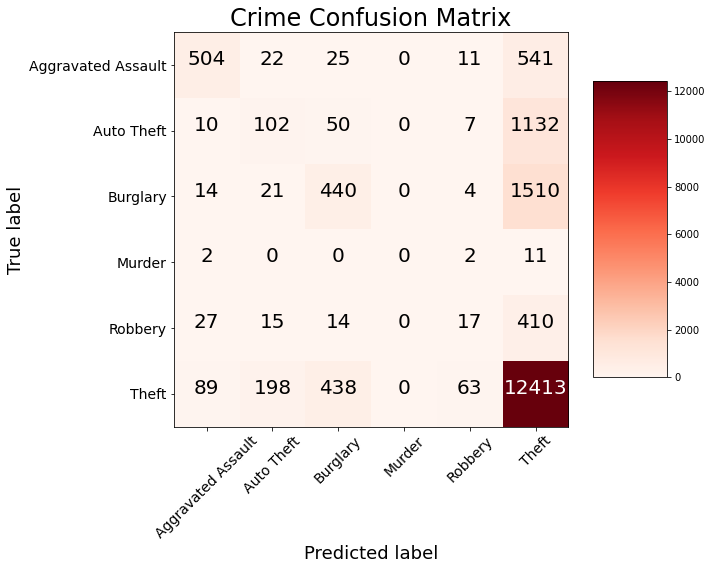

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
             fontsize = 20,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Aggravated Assault', 'Auto Theft', 'Burglary','Murder','Robbery', 'Theft' ],
                      title = 'Crime Confusion Matrix')

In [ ]:
print(rf_model.feature_importances_)
print(f" There are {len(rf_model.feature_importances_)} features in total")

[7.30681748e-02 2.03707051e-01 1.12755622e-02 4.27878797e-02
 7.10581276e-03 5.61121452e-03 5.42835912e-03 8.70042918e-03
 8.86161596e-03 4.17004608e-04 5.77986481e-03 5.27958043e-03
 2.25211035e-04 7.21451640e-03 4.28745696e-04 7.87255328e-03
 1.82655557e-04 8.16507412e-04 5.03362089e-02 5.86759729e-02
 1.47349319e-01 1.15592191e-01 1.22324359e-01 4.78077437e-02
 4.64790520e-02 5.70733012e-03 1.09650840e-02]
 There are 27 features in total


In [ ]:
rf_model.n_features_in_


X_trained_df = cleaned_crime_census_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","APDSector","APDDistrict",
                                  "UCRCategory","CategoryDescription","Latitude","Longitude","OccurredDate_Day", "ZipCode",
                                  "CensusTract"],axis = 1)


In [ ]:
X_trained_df.head(5)

,FamilyViolence,OccurredTime,CouncilDistrict,PRA,Census_Tract,AREA_SQMI,EstimatedTotalPopulation,EstimatedPersonsBelowPoverty,EstimatedPctPersonsBelowPoverty,FlagPctPersonsInPovertyIn90thPercentile,...,SumOfFlagsForSocioeconomicStatus,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist,zipcode_dist
0,False,1700,9,376,7.00,0.62,1121,133,0.119,False,...,0,13,9,9,4,1700,3,0.11880,0.01635,0.19946
1,False,1300,10,177,25.00,1.29,5642,480,0.085,False,...,0,20,7,4,4,1300,1,0.30803,0.02207,0.02243
2,False,1530,2,527,24.22,1.56,5846,682,0.117,False,...,0,1,3,10,1,1500,4,0.08616,0.02551,0.04705
3,False,200,6,574,203.11,2.81,4772,114,0.024,False,...,0,20,3,9,4,200,2,0.17801,0.02211,0.02211
4,False,1815,9,406,11.00,0.94,5719,542,0.097,False,...,0,8,8,9,0,1800,9,0.02136,0.17902,0.19946


In [ ]:
rf_model.feature_importances_

array([7.30681748e-02, 2.03707051e-01, 1.12755622e-02, 4.27878797e-02,
       7.10581276e-03, 5.61121452e-03, 5.42835912e-03, 8.70042918e-03,
       8.86161596e-03, 4.17004608e-04, 5.77986481e-03, 5.27958043e-03,
       2.25211035e-04, 7.21451640e-03, 4.28745696e-04, 7.87255328e-03,
       1.82655557e-04, 8.16507412e-04, 5.03362089e-02, 5.86759729e-02,
       1.47349319e-01, 1.15592191e-01, 1.22324359e-01, 4.78077437e-02,
       4.64790520e-02, 5.70733012e-03, 1.09650840e-02])

In [ ]:
zip(X_trained_df, rf_model.feature_importances_)

TypeError: ignored

In [ ]:
feature_importances = list(zip(X_trained_df, rf_model.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

In [ ]:
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Aggravated Assault       0.00      0.00      0.00      1103
        Auto Theft       0.12      0.01      0.01      1301
          Burglary       0.00      0.00      0.00      1989
            Murder       0.00      1.00      0.00        15
           Robbery       0.00      0.00      0.00       483
             Theft       0.00      0.00      0.00     13201

          accuracy                           0.00     18092
         macro avg       0.02      0.17      0.00     18092
      weighted avg       0.01      0.00      0.00     18092



In [ ]:
precision, r, f,s = precision_recall_fscore_support(y_test,y_pred)

In [ ]:
precision

In [ ]:
y.value_counts()

In [ ]:
# Multinomial Logistic Regression
# y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df.CensusTract
# X = cleaned_crime_df.CensusTract.values.reshape(-1, 1)

y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = cleaned_crime_census_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","APDSector","APDDistrict",
                                  "UCRCategory","CategoryDescription","Latitude","Longitude","OccurredDate_Day", "ZipCode",
                                  "CensusTract"],axis = 1).values
# Split training/test datasets
print(X)

In [ ]:
X.reshape(1, -1)

In [91]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',)
# fit the model on the whole dataset
model.fit(X_train_scaled, y_train)

# define a single row of input data
census_tract_list= cleaned_crime_census_df.CensusTract.unique().tolist()
random_census_tract= random.choice(census_tract_list)
census_tract= [random_census_tract]

In [92]:
# predict the class label
yhat = model.predict(X_test_scaled)
yhat
# summarize the predicted class
# print('Census Tract: %s, Predicted Crime Type: %s' % (census_tract, yhat[0]))

array(['Aggravated Assault', 'Theft', 'Theft', ..., 'Theft', 'Theft',
       'Theft'], dtype=object)

In [93]:
print(classification_report(y_test, yhat))

                    precision    recall  f1-score   support

Aggravated Assault       0.94      0.43      0.59      1103
        Auto Theft       0.00      0.00      0.00      1301
          Burglary       0.30      0.01      0.01      1989
            Murder       0.00      0.00      0.00        15
           Robbery       0.00      0.00      0.00       483
             Theft       0.75      1.00      0.86     13201

          accuracy                           0.75     18092
         macro avg       0.33      0.24      0.24     18092
      weighted avg       0.64      0.75      0.66     18092

